# Trajectory pair

## L5env driverGym

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from prettytable import PrettyTable

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset

from l5kit.dataset import EgoDatasetVectorized
from l5kit.vectorization.vectorizer_builder import build_vectorizer

from l5kit.simulation.dataset import SimulationConfig
from l5kit.simulation.unroll import ClosedLoopSimulator

from l5kit.visualization.visualizer.visualizer import visualize, visualize2, visualize3, visualize4
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI
from bokeh.models import Button


import os

# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/home/pronton/rl/l5kit_dataset/"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("/home/pronton/rl/l5kit/examples/RL/gym_config.yaml")

####################################################
import gym

from stable_baselines3 import SAC, PPO
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import get_linear_fn
from stable_baselines3.common.vec_env import SubprocVecEnv

from l5kit.configs import load_config_data
from l5kit.environment.feature_extractor import CustomFeatureExtractor
from l5kit.environment.callbacks import L5KitEvalCallback
from l5kit.environment.envs.l5_env import SimulationConfigGym

from l5kit.visualization.visualizer.zarr_utils import episode_out_to_visualizer_scene_gym_cle
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show

# Dataset is assumed to be on the folder specified
# in the L5KIT_DATA_FOLDER environment variable

# get environment config
env_config_path = '/home/pronton/rl/l5kit/examples/RL/gg colabs/gym_config.yaml'
cfg = load_config_data(env_config_path)
# Train on episodes of length 32 time steps
train_eps_length = 32
train_envs = 4

# make train env
train_sim_cfg = SimulationConfigGym()
train_sim_cfg.num_simulation_steps = train_eps_length + 1
env_kwargs = {'env_config_path': env_config_path, 'use_kinematic': True, 'sim_cfg': train_sim_cfg}
env = make_vec_env("L5-CLE-v0", env_kwargs=env_kwargs, n_envs=train_envs,
                   vec_env_cls=SubprocVecEnv, vec_env_kwargs={"start_method": "fork"})

# make train env
modelA = SAC.load('/home/pronton/rl/l5kit/examples/RL/gg colabs/logs/SAC_640000_steps.zip', env = env
        #          , custom_objects = {
        #     "learning_rate": 0.0,
        #     "lr_schedule": lambda _: 0.0,
        #     "clip_range": lambda _: 0.0,
        # }
        )

rollout_sim_cfg = SimulationConfigGym()
rollout_sim_cfg.num_simulation_steps = 6

rollout_env = gym.make("L5-CLE-v0", env_config_path=env_config_path, sim_cfg=rollout_sim_cfg, \
                       use_kinematic=True, train=False, return_info=True)

traj = []
def rollout_episode(model, env, idx = 0):
    """Rollout a particular scene index and return the simulation output.

    :param model: the RL policy
    :param env: the gym environment
    :param idx: the scene index to be rolled out
    :return: the episode output of the rolled out scene
    """

    # Set the reset_scene_id to 'idx'
    env.set_reset_id(idx)
    
    # Rollout step-by-step
    obs = env.reset()
    done = False
    while True:
        print('ok')
        action, _ = model.predict(obs, deterministic=True)
        traj.append((obs,action))
        obs, _, done, info = env.step(action)
        if done:
            break

    # The episode outputs are present in the key "sim_outs"
    sim_out = info["sim_outs"][0]
    return sim_out

# Rollout one episode
# sim_out = rollout_episode(model, rollout_env)
# Rollout 5 episodes
sim_outs =[]
for i in range(1):
    sim_outs.append(rollout_episode(modelA, rollout_env, i))

/home/pronton/rl/stable-baselines3/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: an integer is required (got type bytes)
  warnings.warn(
/home/pronton/rl/stable-baselines3/stable_baselines3/common/buffers.py:564: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 6.32GB > 1.14GB
  warnings.warn(
/home/pronton/rl/l5kit/l5kit/l5kit/data/zarr_dataset.py:213: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = ChunkedDataset("")
/home/pronton/rl/l5kit/l5kit/l5kit/simulation/utils.py:107: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  new_dataset = ChunkedDataset("")


ok
ok
ok
ok


In [9]:
print(sim_outs[0].ego_ins_outs[2])

IndexError: list index out of range

In [83]:
print(sim_outs[0].ego_ins_outs[0].inputs)
# print(sim_outs[0].ego_ins_outs[0].inputs)
# print(sim_outs[0].ego_ins_outs[0].outputs)

{'frame_index': 1, 'target_positions': array([[1.0698924 , 0.00859392]], dtype=float32), 'target_yaws': array([[-0.00102448]], dtype=float32), 'target_velocities': array([[10.698924  ,  0.08593918]], dtype=float32), 'target_availabilities': array([1.], dtype=float32), 'history_positions': array([[ 0.        ,  0.        ],
       [-1.0673314 , -0.02274994]], dtype=float32), 'history_yaws': array([[0.        ],
       [0.00039577]], dtype=float32), 'history_velocities': array([[10.673314  ,  0.22749941]], dtype=float32), 'history_availabilities': array([1., 1.], dtype=float32), 'world_to_image': array([[ 1.09597988e+00,  1.67296985e+00,  2.93256109e+03],
       [ 1.67296985e+00, -1.09597988e+00, -3.47549398e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]), 'raster_from_agent': array([[ 2.00000000e+00,  3.92283505e-18,  2.80000000e+01],
       [-1.14945138e-16, -2.00000000e+00,  5.60000000e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]), 'raster_from_

In [ ]:
traj

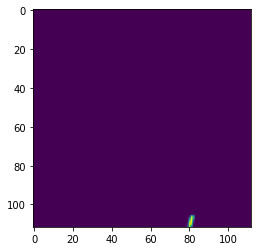

In [24]:
import matplotlib.pyplot as plt
plt.imshow(traj[0][0]['image'][0].reshape(112,112,1))
plt.show()

## L5kit

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from prettytable import PrettyTable

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset

from l5kit.dataset import EgoDatasetVectorized
from l5kit.vectorization.vectorizer_builder import build_vectorizer

from l5kit.simulation.dataset import SimulationConfig
from l5kit.simulation.unroll import ClosedLoopSimulator
from l5kit.cle.closed_loop_evaluator import ClosedLoopEvaluator, EvaluationPlan
from l5kit.cle.metrics import (CollisionFrontMetric, CollisionRearMetric, CollisionSideMetric,
                               DisplacementErrorL2Metric, DistanceToRefTrajectoryMetric)
from l5kit.cle.validators import RangeValidator, ValidationCountingAggregator

from l5kit.visualization.visualizer.zarr_utils import simulation_out_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize, visualize2, visualize3, visualize4
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI
from bokeh.models import Button

from collections import defaultdict
import os
from stable_baselines3 import SAC
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/home/pronton/rl/l5kit_dataset/"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("/home/pronton/rl/l5kit/examples/urban_driver/config.yaml")
model_path = "/home/pronton/rl/l5kit/examples/urban_driver/BPTT.pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load(model_path).to(device)
# model = SAC.load("/home/pronton/rl/l5kit/examples/RL/gg colabs/logs/SAC_640000_steps.zip")
model = model.eval()
torch.set_grad_enabled(False)
# ===== INIT DATASET
eval_cfg = cfg["val_data_loader"]
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
vectorizer = build_vectorizer(cfg, dm)
eval_dataset = EgoDatasetVectorized(cfg, eval_zarr, vectorizer)
print(eval_dataset)
num_scenes_to_unroll = 2
num_simulation_steps = 5
# ==== DEFINE CLOSED-LOOP SIMULATION
sim_cfg = SimulationConfig(use_ego_gt=False, use_agents_gt=True, disable_new_agents=True,
                           distance_th_far=500, distance_th_close=50, num_simulation_steps=num_simulation_steps,
                           start_frame_index=0, show_info=True)

sim_loop = ClosedLoopSimulator(sim_cfg, eval_dataset, device, model_ego=model, model_agents=None)
# ==== UNROLL
scenes_to_unroll = list(range(0, len(eval_zarr.scenes), len(eval_zarr.scenes)//num_scenes_to_unroll))
sim_outs2 = sim_loop.unroll(scenes_to_unroll)

/home/pronton/.virtualenvs/l5kit-nr_j5XnQ/lib/python3.8/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


In [14]:
print(sim_outs2[1].ego_ins_outs[0]) #
# print(sim_outs[0].ego_ins_outs)

UnrollInputOutput(track_id=-1, inputs={'extent': array([4.87, 1.85, 1.8 ]), 'type': 3, 'agent_from_world': array([[ 5.42973291e-01,  8.39749966e-01,  1.14696021e+03],
       [-8.39749966e-01,  5.42973291e-01,  1.75962668e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]), 'world_from_agent': array([[ 5.42973291e-01, -8.39749966e-01,  8.54877686e+02],
       [ 8.39749966e-01,  5.42973291e-01, -1.91859009e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]), 'target_positions': array([[ 1.3527883e+00, -4.9783797e-03],
       [ 2.6251454e+00, -1.3453717e-03],
       [ 3.9688060e+00, -7.7193705e-03],
       [ 5.3020959e+00, -2.6831431e-02],
       [ 0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00